In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.integrate import simps
from scipy.optimize import brentq

import sys
import dill

from functools import partial
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

In [3]:
sys.path.append('..')

In [4]:
from finance.discountfactor import ConstantRateDiscountFactor
from finance.products.european.swap import SwapContract
from utils import time_offseter

loaded_data = None

with open('precomputed_sims/data1.pkl', 'rb') as f:
    loaded_data = dill.load(f)
    
step = 1 / 360.
delta = 5 * step

maturity = loaded_data["randomization"]["maturity"]
print "Maturity = %s years" % maturity

r = 0.02
discount = ConstantRateDiscountFactor(r)

udlyings = loaded_data["underlyings"]
print "Maximum number of paths: %i" % len(udlyings)

GBM0 = udlyings[0]
kappa = GBM0.drifts[0][0]
sigma = GBM0.vols[0][0]
print "kappa = %s, sigma = %s" % (kappa, sigma)

time_grid = GBM0.time

derivatives_nb = 1

swap_delta = 0.25
swap_dates = SwapContract.generate_payment_dates(0, maturity, swap_delta)
swap = SwapContract(GBM0, discount, swap_dates)

print swap

p_fixed = 1.
strike = swap.strike

delta_times = swap.delta_time
discount_factors = [discount(t) for t in swap.pillars[1:]]

delta_beta_sum = np.dot(delta_times, discount_factors)

notional = p_fixed / (strike * delta_beta_sum)

print "Notional on the swap: %s" % notional

copula = loaded_data["credit"]["copula"]
c_subsets_indexes = loaded_data["credit"]["bc_subsets_indexes"]
obligors_nb = len(copula.subsets[c_subsets_indexes[-1]][0])
print "Obligor numbers: %s" % obligors_nb

c_ids = [17, 9, 29, 26, 50, 4, 5, 13, 64]
c_positions = [0.69, -0.46, -0.44, -0.36, 0.34, 0.23, 0.09, -0.05, -0.04]

print "Counterparties id: %s (nb = %s)" % (c_ids, len(c_ids))

POSITIONS = np.zeros(obligors_nb)
for idx, ps in zip(c_ids, c_positions):
    POSITIONS[idx] = ps

POSITIONS = POSITIONS / -POSITIONS[13]
POSITIONS = np.array(POSITIONS).flatten()

print POSITIONS

spreads = [176, 45, 367, 1053, 73, 56, 52, 61, 108]
IDS_SPREADS = dict((id_, spread_) for (id_, spread_) in zip(c_ids, spreads))
IDS_POSITIONS = dict((id_, pos_) for (id_, pos_) in zip(c_ids, c_positions))

Maturity = 5.0 years
Maximum number of paths: 20000
kappa = 0.12, sigma = 0.2
Swap contract of maturity T = 5 years, over S^0 with strike K = 134.306, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}
Notional on the swap: 0.0015687485053
Obligor numbers: 125
Counterparties id: [17, 9, 29, 26, 50, 4, 5, 13, 64] (nb = 9)
[  0.    0.    0.    0.    4.6   1.8   0.    0.    0.   -9.2   0.    0.
   0.   -1.    0.    0.    0.   13.8   0.    0.    0.    0.    0.    0.
   0.    0.   -7.2   0.    0.   -8.8   0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    6.8   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.   -0.8   0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    

In [5]:
QUANTILES = np.linspace(0.85, 0.997, 20)
LOIM_PATH = './res/aggregated/loss_over_im'

HURDLE_RATE = 0.1

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [6]:
def fact_(swap_, discount_, kappa_, delta_, t_):
    time_grid_ = swap_.underlying.time
    t_delta_ = time_offseter(t_ + delta_, time_grid_, True)
    
    coupon_dates_ = swap_.pillars
    l_t_delta_ = np.searchsorted(coupon_dates_, t_delta_, side='left')

    beta_T_l_ = map(discount_, coupon_dates_[l_t_delta_ + 1 :])    
    h_l_ = swap_.delta_time[l_t_delta_ : ]
    
    T_l_m1_ = kappa_ * coupon_dates_[l_t_delta_ : -1]
    exp_factor_ = map(np.exp, T_l_m1_)
    
    tmp_ = np.multiply(exp_factor_, h_l_)    
    res_ = np.dot(beta_T_l_, tmp_)
    
    return res_

fact = partial(fact_, swap, discount, kappa, delta)

In [7]:
def B_(fact_f_, vol_, delta_, a_, omega_, t_):
    if a_ <= 0.5: 
        a_ = 1. - a_
    
    perc_ = a_ if omega_ <= 0. else (1. - a_)
    q_ = norm.ppf(perc_)
    
    var_ = vol_**2 * delta_
    exp_factor_ = np.exp(-0.5 * var_ + np.sqrt(var_) * q_)
    
    tmp_res_ = 1. - exp_factor_
    
    return np.sign(omega_) * tmp_res_ * fact_f_(t_)

B = partial(B_, fact, sigma, delta)

In [8]:
def map_id_label(c_id_):
    pos_ = POSITIONS[c_id_]
    spread_ =  IDS_SPREADS[c_id_]
    
    pos_string_ = "%.2f" % abs(pos_)
    if pos_ < 0:
        pos_string_ = "(" + pos_string_ + ")"
    
    return '%i bps \n%s' % (spread_, pos_string_) 

In [9]:
def str_quantile(x):
    q = x * 100
    str_q = '%.1f' % q
    if str_q[-1] == '0':
        return str_q[:-2] + '%'
    
    return str_q + '%'

In [10]:
def compute_mva0(sorted_bc_ids_):
    df_mva0 = pd.DataFrame()
    R = 0.4
    S0 = GBM0(0.)[0, 0]
    
    for alpha in QUANTILES:
        for id_ in sorted_bc_ids_:
            label_id_ = map_id_label(id_)
            
            pos_ = POSITIONS[id_]
            nom_i = np.abs(pos_) * notional
            
            factor = S0 * (1 - R) * nom_i
        
            def integrand(t_):
                Bt_ = B(alpha, pos_, t_)
                gamma_t_ = copula.tot_gamma(t_, id_)
                surv_proba_t_ = copula.tot_survival_proba(t_, id_)

                return Bt_ * gamma_t_ * surv_proba_t_
        
            sub_indexes_ = copula.get_indexes_including(id_)
            int_pillars_ = set(copula.pillars[sub_indexes_].flatten())
            swap_pillars_ = set(swap.pillars)

            cut_times_ = list(int_pillars_ | swap_pillars_)
            cut_times_.sort()

            integral_ = 0.
            for t_i_, t_ip1_ in zip(cut_times_[:-1], cut_times_[1:]):
                x__ = np.linspace(t_i_, t_ip1_, 10)
                y__ = map(integrand, x__)
                tmp_int__ = simps(y__, x__)
                integral_ += tmp_int__

            mva0 = factor * integral_
            df_mva0.set_value(label_id_, str_quantile(alpha), mva0)
    return df_mva0

In [11]:
mva0 = compute_mva0(c_ids)
mva0
#mva0.plot.bar(rot=0);

,85%,85.8%,86.5%,87.3%,88.1%,88.9%,89.6%,90.4%,91.2%,92%,92.7%,93.5%,94.3%,95.1%,95.8%,96.6%,97.4%,98.2%,98.9%,99.7%
176 bps \n13.80,0.014911,0.015385,0.015877,0.016388,0.016921,0.017479,0.018064,0.018681,0.019336,0.020034,0.020784,0.021596,0.022487,0.023477,0.024597,0.025898,0.027467,0.029482,0.032397,0.038477
45 bps \n(9.20),0.002659,0.002748,0.002840,0.002936,0.003036,0.003141,0.003252,0.003368,0.003492,0.003625,0.003768,0.003923,0.004094,0.004284,0.004500,0.004752,0.005057,0.005451,0.006027,0.007246
367 bps \n(8.80),0.019379,0.020025,0.020697,0.021396,0.022126,0.022891,0.023697,0.024547,0.025451,0.026418,0.027459,0.028590,0.029833,0.031218,0.032792,0.034628,0.036853,0.039726,0.043920,0.052806
1053 bps \n(7.20),0.037329,0.038575,0.039868,0.041215,0.042622,0.044096,0.045647,0.047286,0.049027,0.050889,0.052894,0.055073,0.057467,0.060136,0.063168,0.066704,0.070991,0.076525,0.084604,0.101721
73 bps \n6.80,0.003107,0.003206,0.003309,0.003415,0.003526,0.003642,0.003764,0.003893,0.004029,0.004175,0.004331,0.004501,0.004686,0.004892,0.005126,0.005397,0.005724,0.006144,0.006751,0.008018
56 bps \n4.60,0.001700,0.001755,0.001811,0.001869,0.001930,0.001993,0.002060,0.002130,0.002205,0.002285,0.002370,0.002463,0.002564,0.002677,0.002805,0.002953,0.003132,0.003362,0.003695,0.004388
52 bps \n1.80,0.000609,0.000628,0.000648,0.000669,0.000691,0.000713,0.000737,0.000763,0.000789,0.000818,0.000848,0.000882,0.000918,0.000958,0.001004,0.001057,0.001121,0.001203,0.001322,0.001571
61 bps \n(1.00),0.000383,0.000396,0.000409,0.000423,0.000438,0.000453,0.000469,0.000486,0.000503,0.000523,0.000543,0.000566,0.000590,0.000618,0.000649,0.000685,0.000729,0.000786,0.000869,0.001045
108 bps \n(0.80),0.000535,0.000553,0.000571,0.000591,0.000611,0.000632,0.000654,0.000678,0.000703,0.000729,0.000758,0.000789,0.000824,0.000862,0.000905,0.000956,0.001018,0.001097,0.001213,0.001458


In [12]:
def compute_im0(sorted_bc_ids_):
    df_im0 = pd.DataFrame()
    S0 = GBM0(0.)[0, 0]
    
    for alpha in QUANTILES:
        for id_ in sorted_bc_ids_:
            label_id_ = map_id_label(id_)
            
            pos_ = POSITIONS[id_]
            nom_i = np.abs(pos_) * notional
            
            im0 = S0 * nom_i * B(alpha, pos_, 0.)
            
            df_im0.set_value(label_id_, str_quantile(alpha), im0)
            
    return df_im0

In [13]:
im0 = compute_im0(c_ids)

im0 = im0.transpose()
im0['Total IM'] = im0.sum(axis=1)

im0 = im0.transpose()

im0
#im0.plot.bar(rot=0);

,85%,85.8%,86.5%,87.3%,88.1%,88.9%,89.6%,90.4%,91.2%,92%,92.7%,93.5%,94.3%,95.1%,95.8%,96.6%,97.4%,98.2%,98.9%,99.7%
176 bps \n13.80,0.323634,0.333929,0.344601,0.355695,0.367260,0.379357,0.392061,0.405460,0.419664,0.434814,0.451091,0.468731,0.488061,0.509541,0.533856,0.562095,0.596159,0.639873,0.703141,0.835121
45 bps \n(9.20),0.216120,0.223332,0.230822,0.238620,0.246763,0.255298,0.264277,0.273766,0.283848,0.294626,0.306233,0.318847,0.332709,0.348161,0.365716,0.386189,0.411006,0.443049,0.489822,0.588923
367 bps \n(8.80),0.206723,0.213622,0.220786,0.228245,0.236034,0.244198,0.252786,0.261863,0.271507,0.281816,0.292919,0.304984,0.318243,0.333024,0.349815,0.369398,0.393136,0.423786,0.468525,0.563318
1053 bps \n(7.20),0.169137,0.174782,0.180643,0.186746,0.193119,0.199798,0.206825,0.214252,0.222142,0.230577,0.239661,0.249532,0.260381,0.272474,0.286213,0.302235,0.321657,0.346734,0.383339,0.460896
73 bps \n6.80,0.159472,0.164545,0.169803,0.175270,0.180969,0.186930,0.193189,0.199792,0.206791,0.214256,0.222276,0.230969,0.240494,0.251078,0.263060,0.276975,0.293760,0.315300,0.346475,0.411509
56 bps \n4.60,0.107878,0.111310,0.114867,0.118565,0.122420,0.126452,0.130687,0.135153,0.139888,0.144938,0.150364,0.156244,0.162687,0.169847,0.177952,0.187365,0.198720,0.213291,0.234380,0.278374
52 bps \n1.80,0.042213,0.043556,0.044948,0.046395,0.047903,0.049481,0.051138,0.052886,0.054739,0.056715,0.058838,0.061139,0.063660,0.066462,0.069633,0.073317,0.077760,0.083462,0.091714,0.108929
61 bps \n(1.00),0.023491,0.024275,0.025089,0.025937,0.026822,0.027750,0.028726,0.029757,0.030853,0.032025,0.033286,0.034657,0.036164,0.037844,0.039752,0.041977,0.044675,0.048158,0.053241,0.064013
108 bps \n(0.80),0.018793,0.019420,0.020071,0.020750,0.021458,0.022200,0.022981,0.023806,0.024682,0.025620,0.026629,0.027726,0.028931,0.030275,0.031801,0.033582,0.035740,0.038526,0.042593,0.051211
Total IM,1.267460,1.308771,1.351631,1.396221,1.442748,1.491465,1.542671,1.596735,1.654114,1.715387,1.781296,1.852829,1.931330,2.018706,2.117799,2.233132,2.372612,2.552178,2.813231,3.362293


In [14]:
def objective_es_quantile(q_, total_im, serie_):
    var_ = serie_.quantile(q_, interpolation='linear')
    es_ = serie_[serie_ >= var_].mean()
    
    return es_ - 0.1 * total_im

In [15]:
def map_es0_quantile(q):
    str_int = '[0.00, 1.00]'
    fname = 'loim_%s_%s.csv' % (str_int, q)
    loim_q_path = os.path.join(LOIM_PATH, fname)
    loim_df = pd.read_csv(loim_q_path, header=0, index_col=0)
    
    loim_ser = loim_df.sum(axis=1)
    
    total_im = im0[str_quantile(q)]['Total IM']
    
    res = brentq(objective_es_quantile, 0., 1., args=(total_im, loim_ser))
    return res

In [16]:
ES_QUANTILES = map(map_es0_quantile, QUANTILES)
ES_QUANTILES

[0.9590295902970625,
 0.9631696316953048,
 0.9670696706964345,
 0.9707897078956392,
 0.9742697426982707,
 0.9775397753989266,
 0.9806098060982292,
 0.9834398343987314,
 0.9860598605979853,
 0.9884398843987415,
 0.9905799057983607,
 0.9925199251985151,
 0.9942199421976848,
 0.9956799567998105,
 0.9969099691007918,
 0.9979299793007647,
 0.9987299872986705,
 0.9993199932002221,
 0.9997499974998814,
 0.9999899999008471]

In [17]:
def compute_1y_ahead_varrho_ccp(times_cva_, shifted_times_cva_):
    varrho_ccp_ = {}
    col_names_ = ['all', 17, 9, 29, 26, 50, 4, 5, 13, 64]
    
    for q_ in QUANTILES:
        varrho_ccp_[q_] = {}
        for t0_, t1_ in zip(times_cva_, shifted_times_cva_):
            str_int_ = "[%.2f, %.2f]" % (t0_, t1_)
            fname_ = 'loim_%s_%s.csv' % (str_int_, q_)
            loim_q_path_ = os.path.join(LOIM_PATH, fname_)
            loim_df_ = pd.read_csv(loim_q_path_, header=0, index_col=0)

            varrho_ccp_t0_t1_ = {}

            for col_ in col_names_:
                loss_ = loim_df_
                if col_ != 'all':
                    col_ = unicode(col_)
                    loss_ = loim_df_.drop(col_, 1)
                    
                varrho_ser = loss_.sum(axis=1)
                varrho_ccp_t0_t1_[col_] = loss_.sum(axis=1)

            varrho_ccp_[q_][str_int_] = pd.DataFrame(varrho_ccp_t0_t1_)
    
    return varrho_ccp_

In [18]:
loss_ccp = compute_1y_ahead_varrho_ccp(times_cva, shifted_times_cva)

#for k, v in loss_ccp.iteritems():
#    for kk, vv in v.iteritems():
#        print k, kk

In [19]:
def compute_kva(r_, h_, times_cva_, maturity_, df_serie_):    
    time_grid_ = np.append(times_cva_, maturity)
    
    exp_factors_ = np.exp(-(r_ + h_) * time_grid_)
    delta_exp_factors_ = np.ediff1d(exp_factors_)
    
    df_exp_ = delta_exp_factors_ * df_serie_
    
    kva_ = -h_ / (r_ + h_) * df_exp_
    kva_ = kva_[::-1].cumsum()[::-1]
    return kva_

In [20]:
cols = ['all', '17', '9', '29', '26', '50', '4', '5', '13', '64']

expected_shortfall = {}
kva = {}

for col in cols:
    expected_shortfall[col] = {}
    kva[col] = {}
    for i, q in enumerate(QUANTILES):
        cur_loss = loss_ccp[q]
        q_es = ES_QUANTILES[i]

        loim = pd.DataFrame()
        for t0, t1 in zip(times_cva, shifted_times_cva):
            str_int = "[%.2f, %.2f]" % (t0, t1)
            loim[str_int] = cur_loss[str_int][col]

        var = loim.quantile(q_es, interpolation='linear')
        es = loim[loim >= var].mean(axis=0)
        expected_shortfall[col][q] = es
        kva[col][q] = compute_kva(r, HURDLE_RATE, times_cva, maturity, es)        
    
    expected_shortfall[col] = pd.DataFrame(expected_shortfall[col])
    kva[col] = pd.DataFrame(kva[col])

In [21]:
calib_default_fund = expected_shortfall['all']
kva_ccp = kva['all']

In [22]:
ratios_ec = {}
ratios_kva = {}

for q in QUANTILES:
    ratios_ec[q] = pd.DataFrame()
    ratios_kva[q] = pd.DataFrame()
    for col in cols:
        if col == 'all':
            continue
        
        ratios_ec[q][col] = expected_shortfall['all'][q] - expected_shortfall[col][q]
        ratios_kva[q][col] = kva['all'][q] - kva[col][q]
        
    sum_ec_ = ratios_ec[q].sum(axis=1)
    ratios_ec[q] = ratios_ec[q].div(sum_ec_, axis=0)
    
    sum_kva_ = ratios_kva[q].sum(axis=1)
    ratios_kva[q] = ratios_kva[q].div(sum_kva_, axis=0)

In [23]:
integral_for_kva = pd.DataFrame()

for col in cols:
    if col == 'all':
        continue

    id_ = int(col)
    
    for t0, t1 in zip(times_cva, shifted_times_cva):
        def integrand(s):
            surv_proba_s = copula.tot_survival_proba(s, id_)
            h_exp = np.exp(-(r + HURDLE_RATE) * s)
            return surv_proba_s * h_exp

        x = np.linspace(t0, t1, 10)
        y = map(integrand, x)
        integral = simps(y, x)
        
        str_int = "[%.2f, %.2f]" % (t0, t1)
        integral_for_kva.set_value(str_int, col, integral)

In [24]:
kva_key_ec = {}
kva_key_kva = {}

for q in QUANTILES:
    df_ec_ = (ratios_ec[q] * integral_for_kva).multiply(calib_default_fund[q], axis=0)
    df_kva_ = (ratios_kva[q] * integral_for_kva).multiply(calib_default_fund[q], axis=0)
    
    kva_key_ec[q] = HURDLE_RATE * df_ec_[::-1].cumsum(axis=0)[::-1]
    kva_key_kva[q] = HURDLE_RATE * df_kva_[::-1].cumsum(axis=0)[::-1]    

In [25]:
kva0_ec = pd.DataFrame(index=map(map_id_label, c_ids), columns=map(str_quantile, QUANTILES))
kva0_kva = pd.DataFrame(index=map(map_id_label, c_ids), columns=map(str_quantile, QUANTILES))

for q in QUANTILES:
    str_int = '[0.00, 1.00]'
    
    tmp_kva_ec = kva_key_ec[q].transpose()[str_int]    
    tmp_kva_ec.index = tmp_kva_ec.index.map(lambda x: map_id_label(int(x)))
    kva0_ec[str_quantile(q)] = tmp_kva_ec
    
    tmp_kva_kva = kva_key_kva[q].transpose()[str_int]    
    tmp_kva_kva.index = tmp_kva_kva.index.map(lambda x: map_id_label(int(x)))
    kva0_kva[str_quantile(q)] = tmp_kva_kva

In [26]:
from matplotlib.ticker import FuncFormatter

formatter_bps = FuncFormatter(lambda y, pos: "%.0f" % (10**4 * y))

In [27]:
def plot(ordered_labels):
    for q in QUANTILES:
        str_q = str_quantile(q)
        tmp_dict = {r'$MVA_0$': mva0[str_q],
                    r'$KVA_0^{ec}$': kva0_ec[str_q], 
                    r'$KVA_0^{kva}$': kva0_kva[str_q]}

        tmp_df = pd.DataFrame(tmp_dict)
        tmp_df = tmp_df.reindex(ordered_labels)
        tmp_df.plot.bar(rot=0, title=r'$a_{IM} = %s\%%$' % str_q[:-1])
        plt.gca().yaxis.set_major_formatter(formatter_bps)

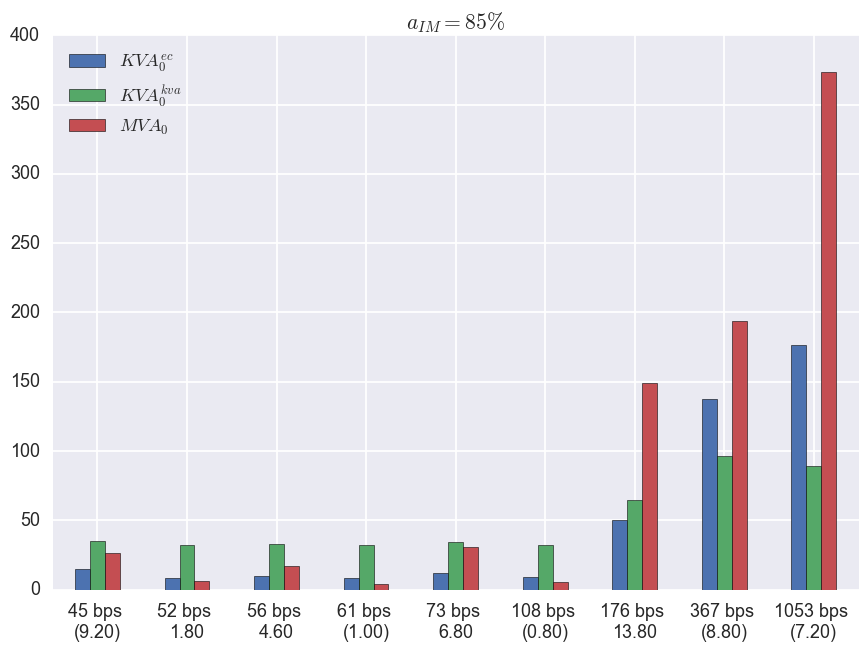

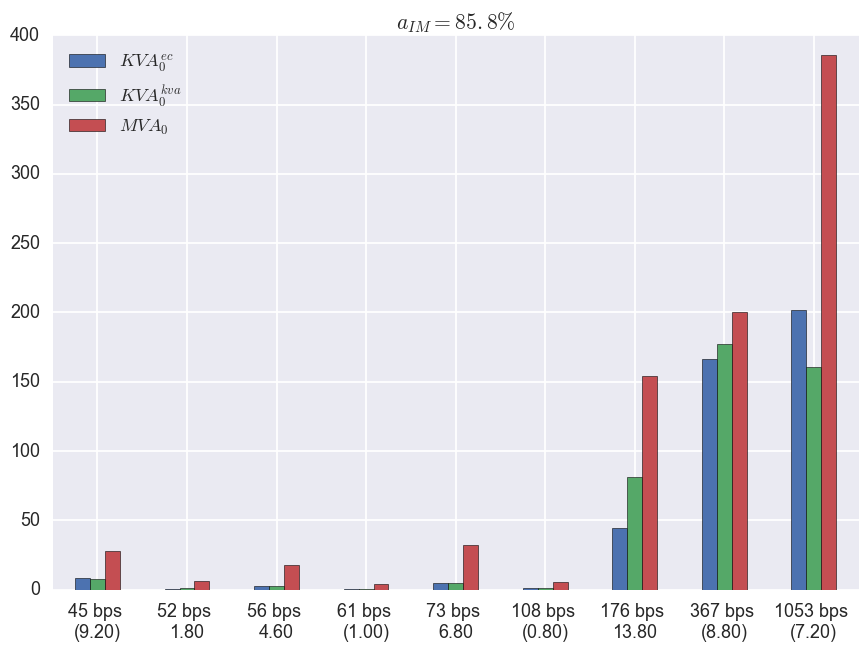

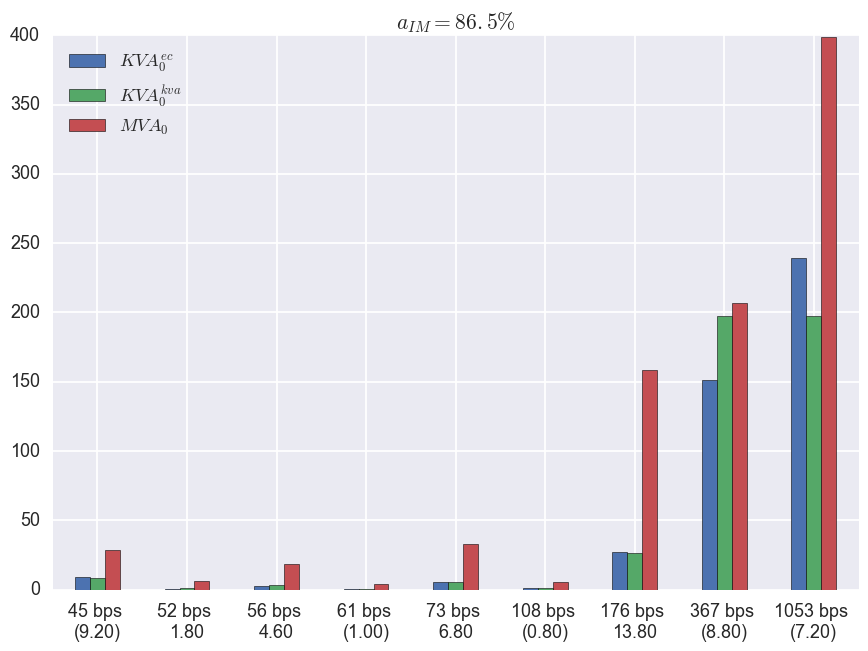

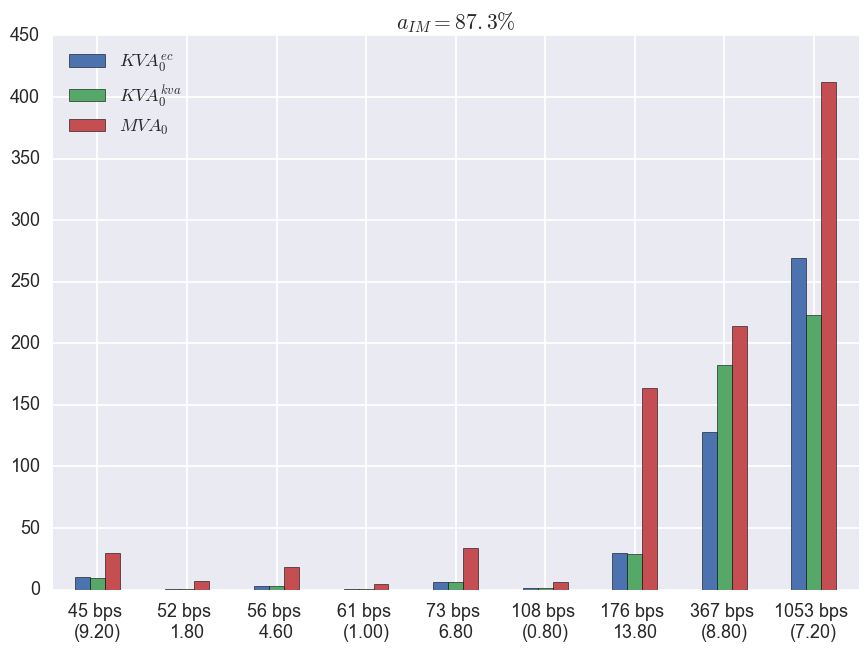

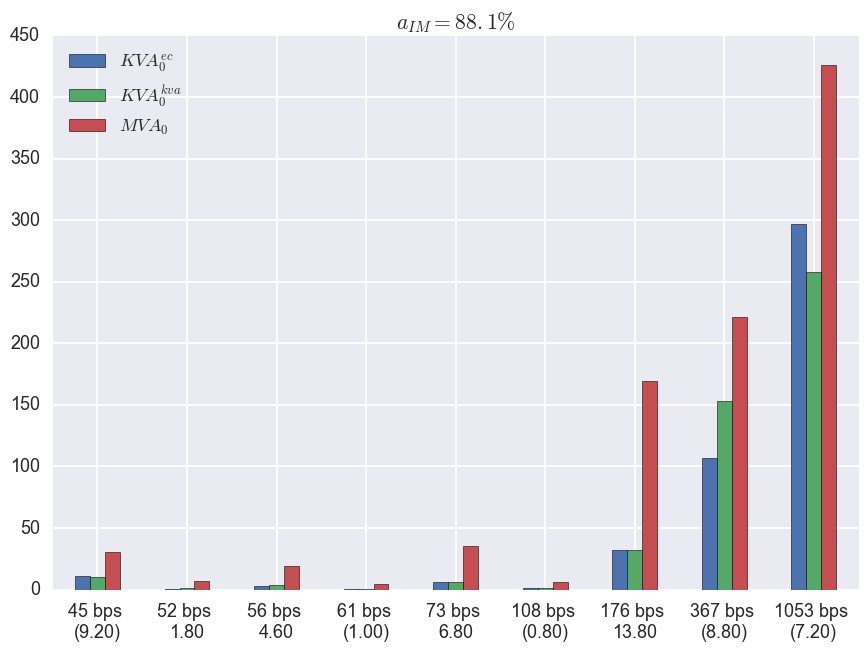

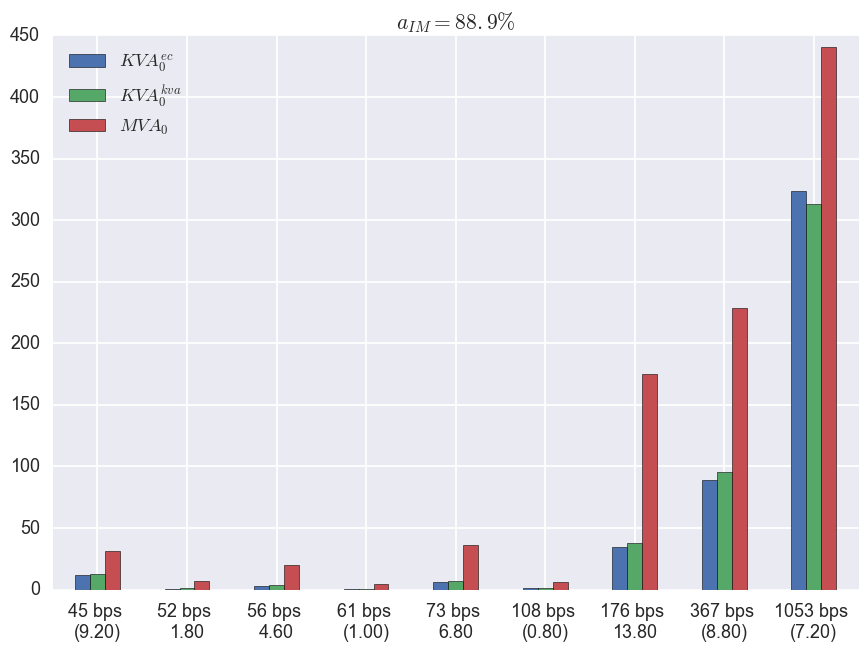

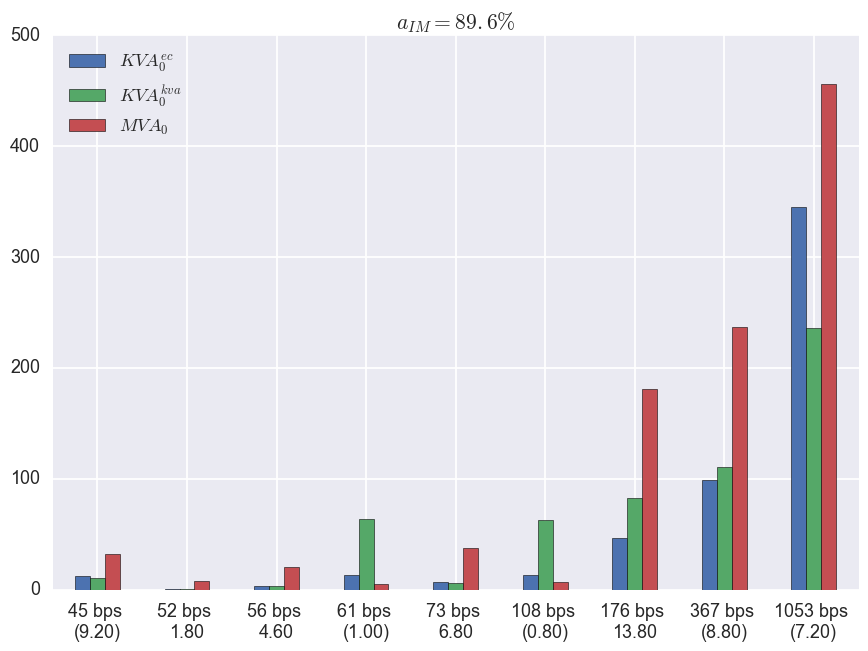

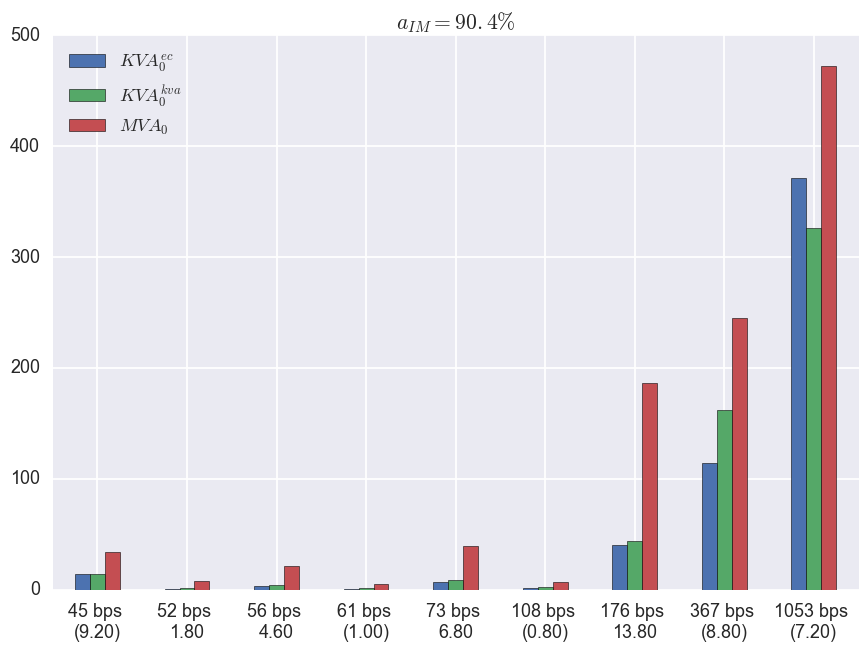

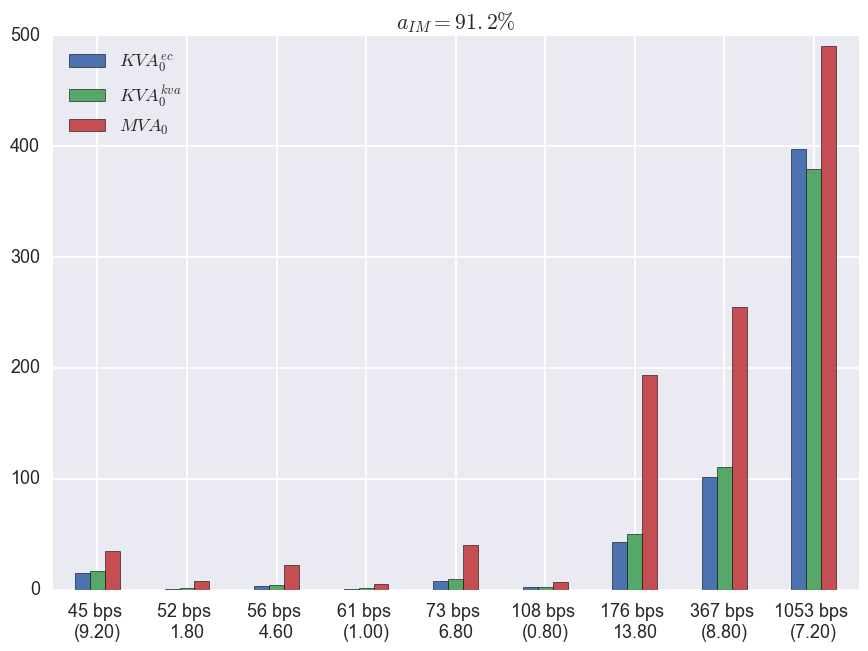

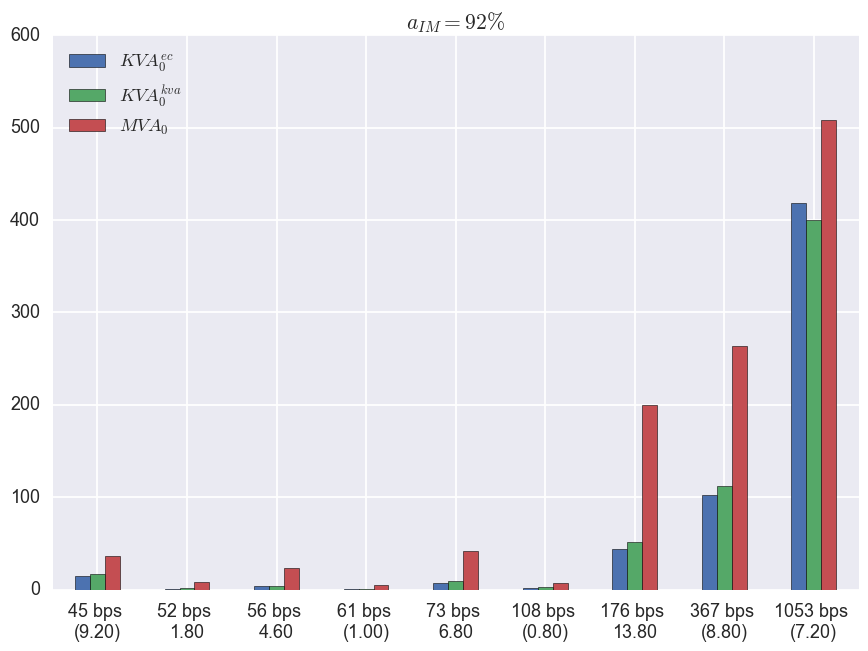

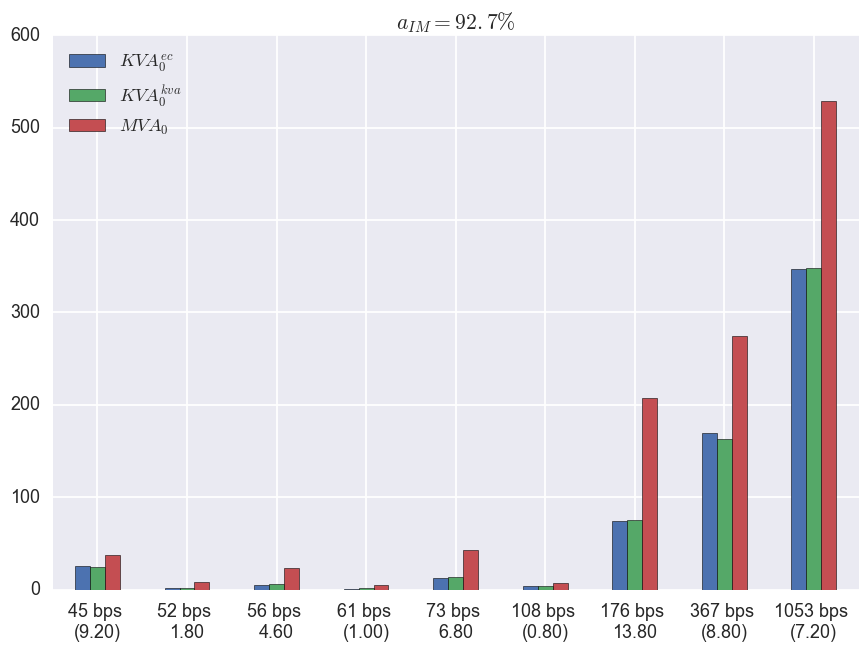

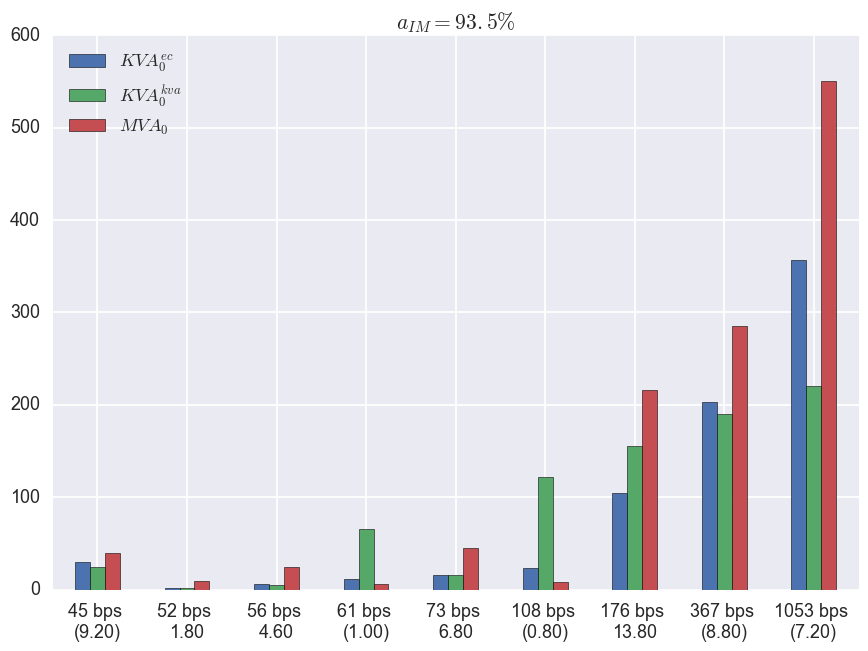

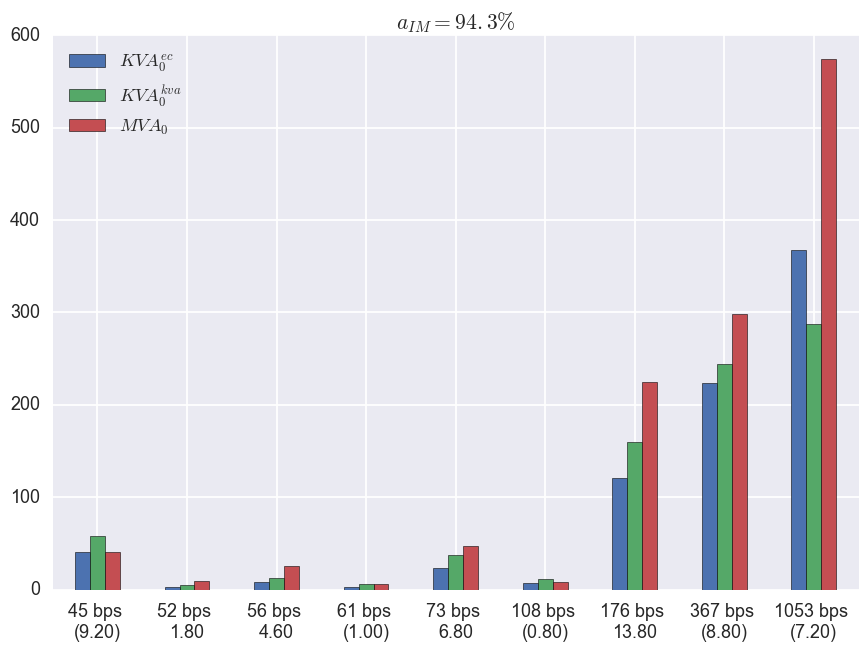

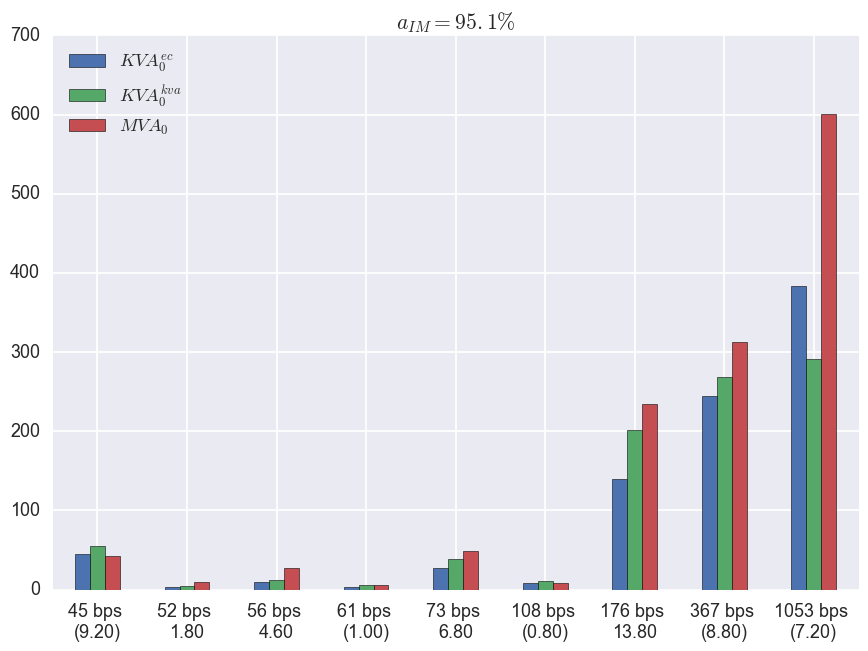

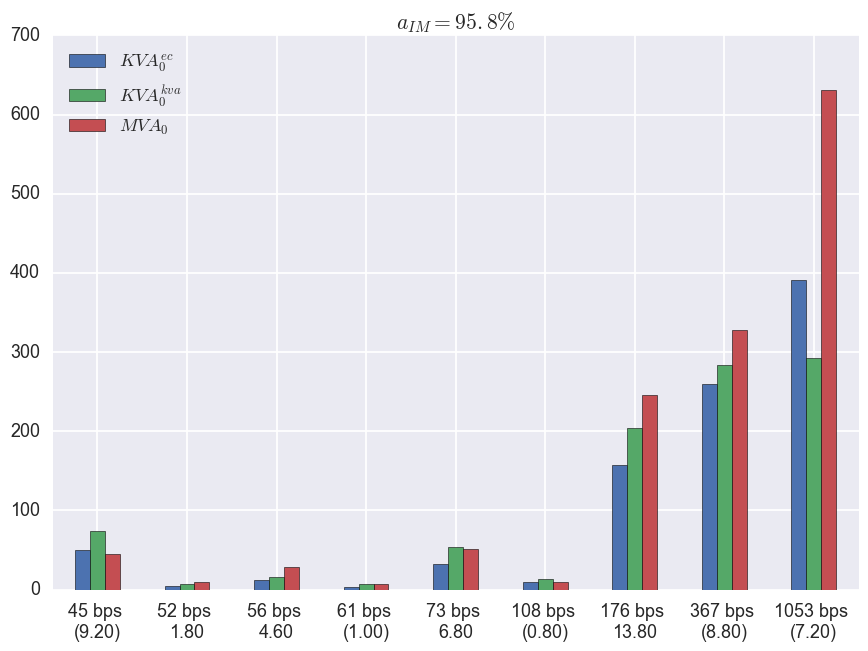

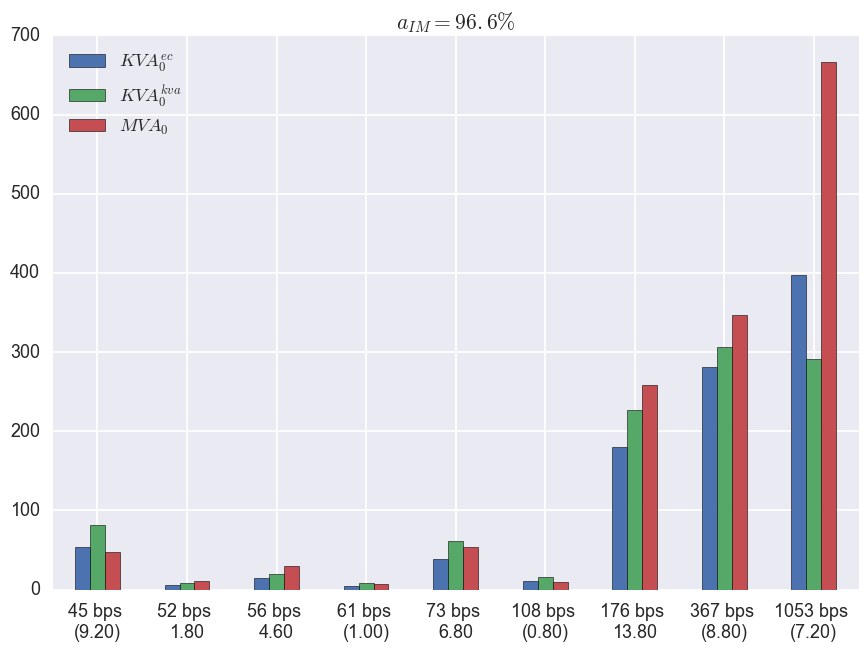

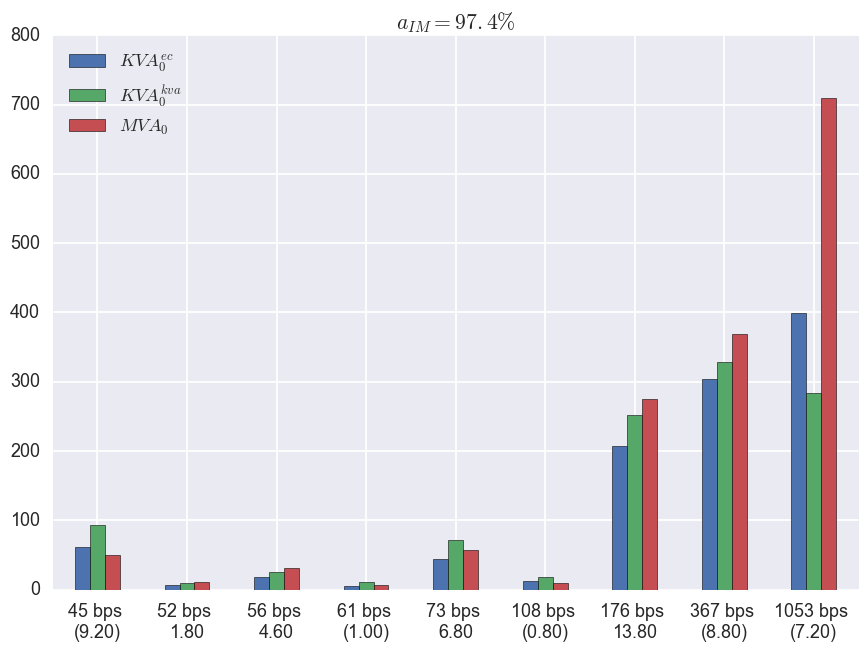

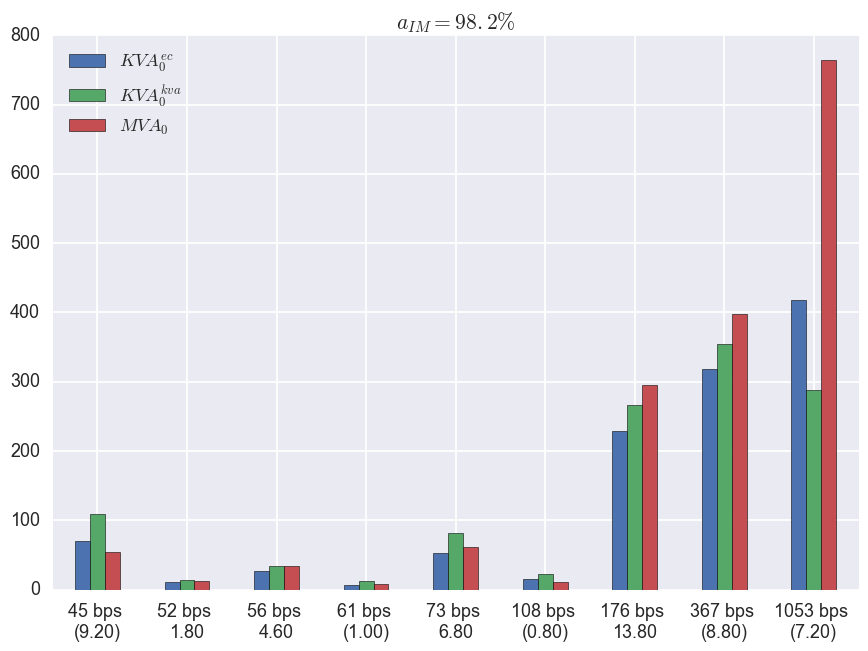

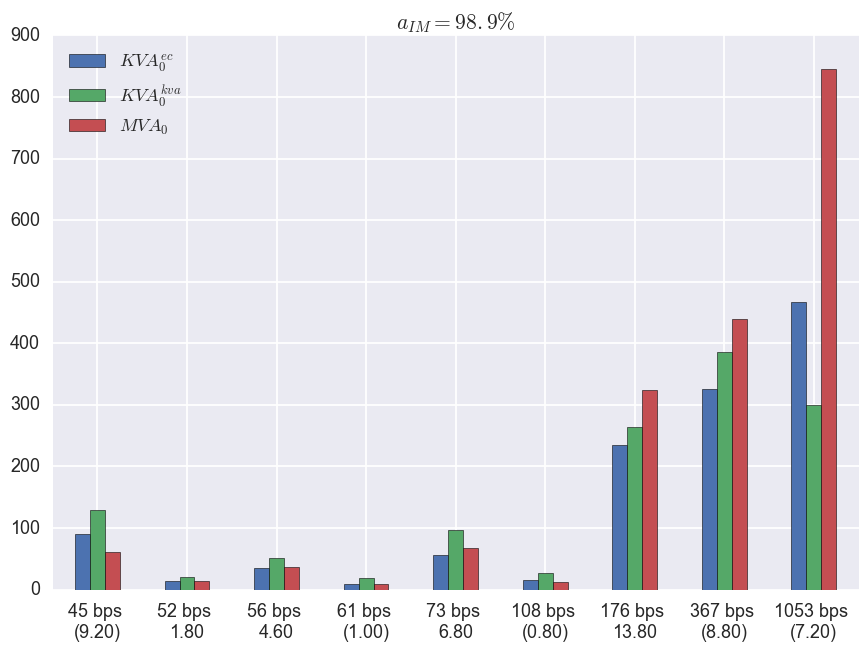

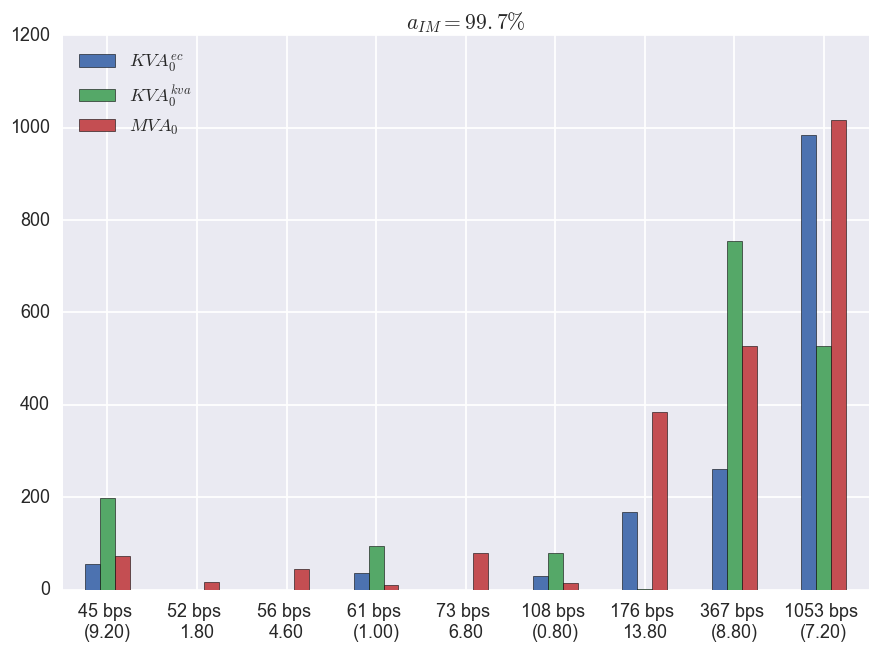

In [28]:
sorted_bc_ids = sorted(IDS_SPREADS.items(), key=lambda x: x[1])
sorted_bc_ids = [x[0] for x in sorted_bc_ids]
labels_spreads = map(map_id_label, sorted_bc_ids)

plot(labels_spreads)

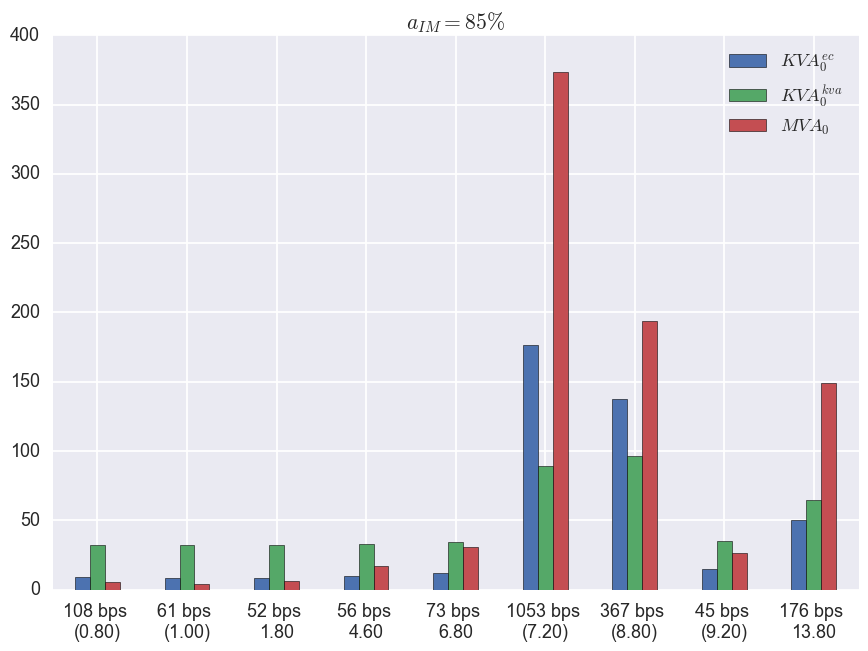

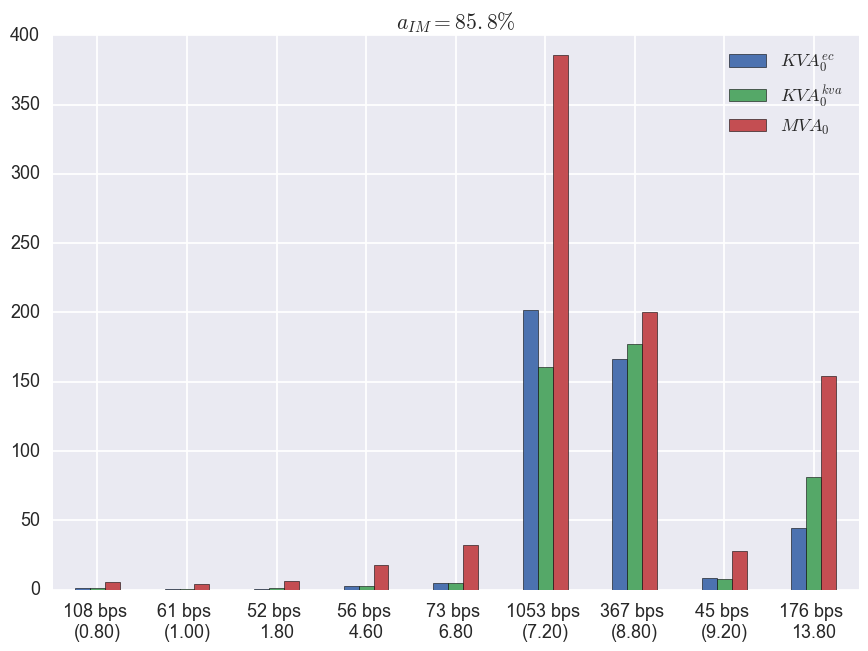

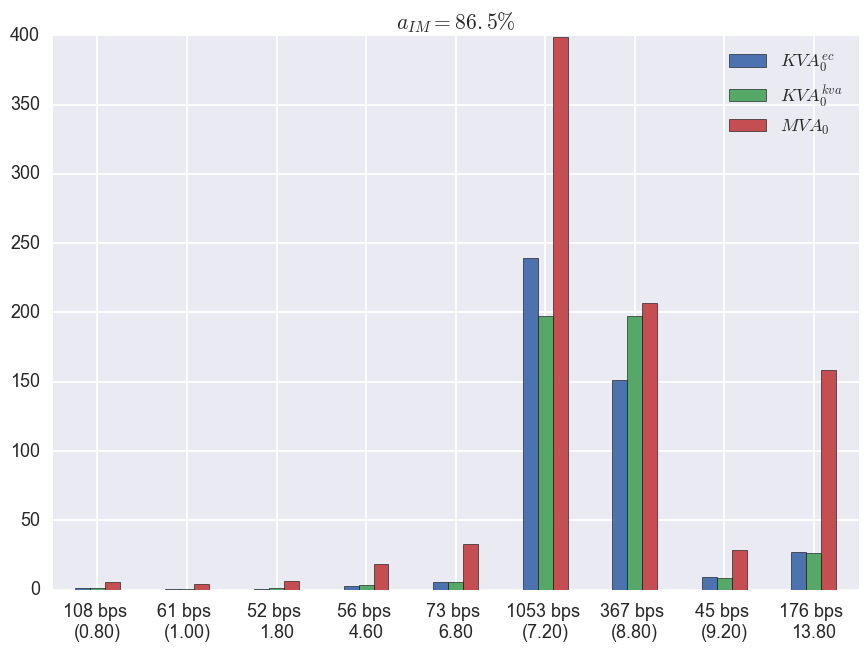

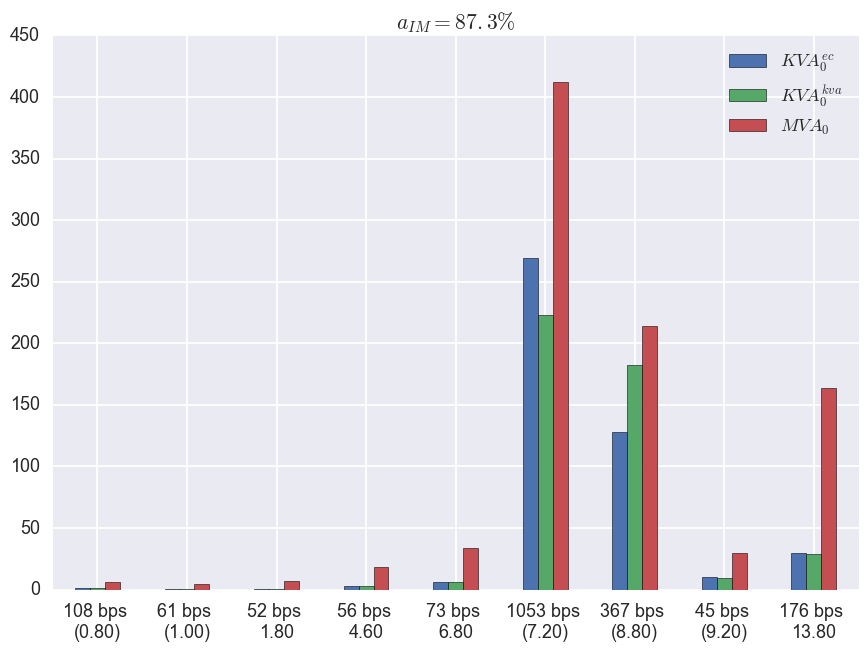

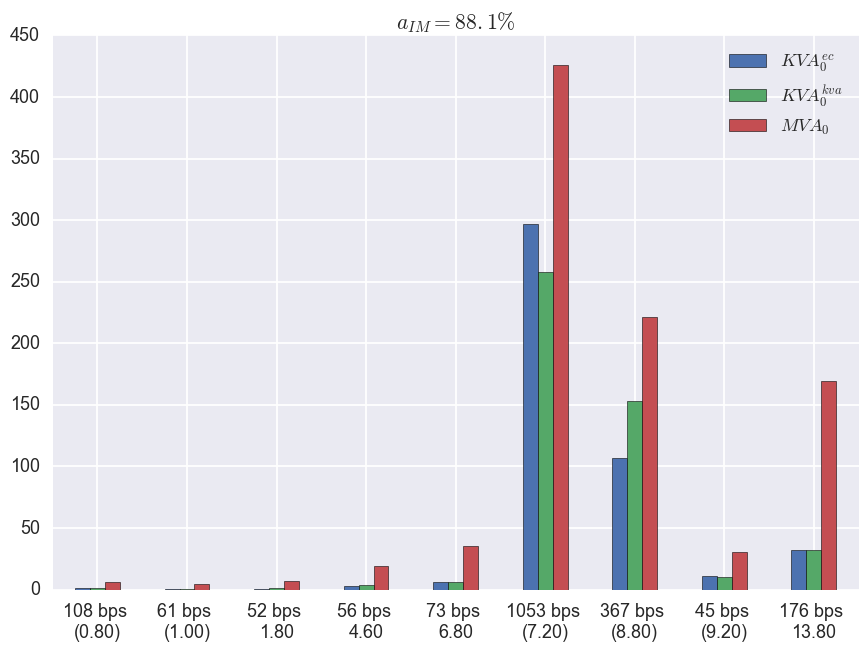

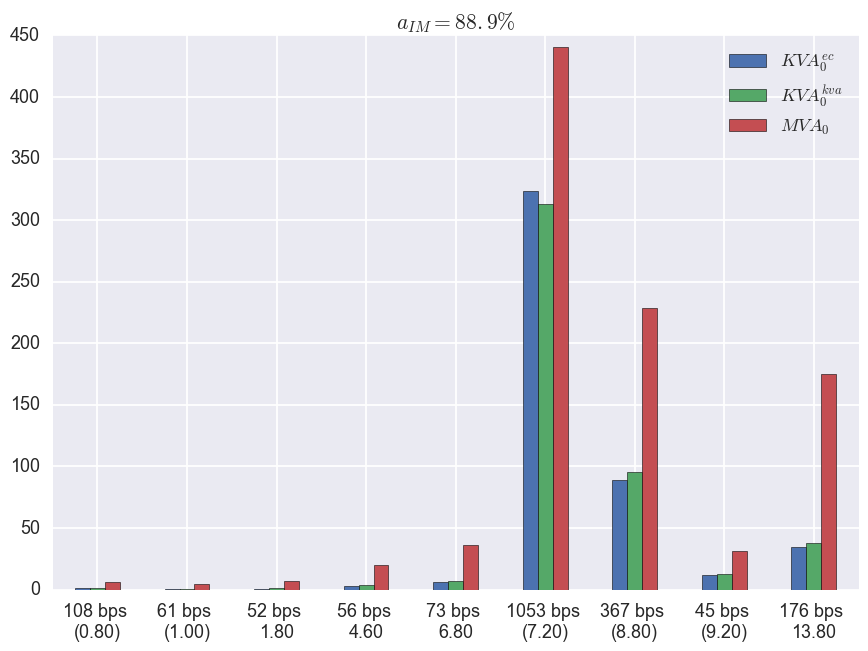

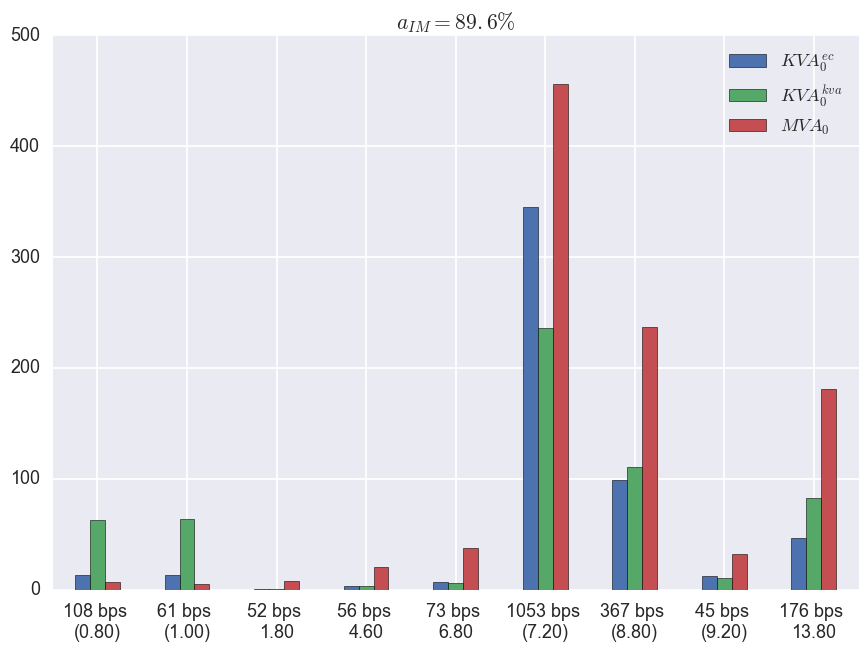

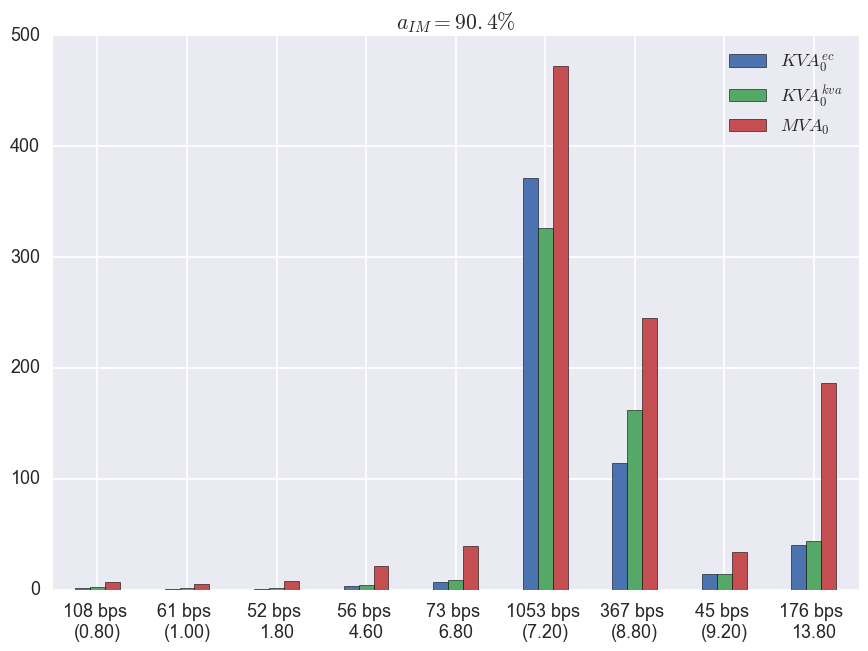

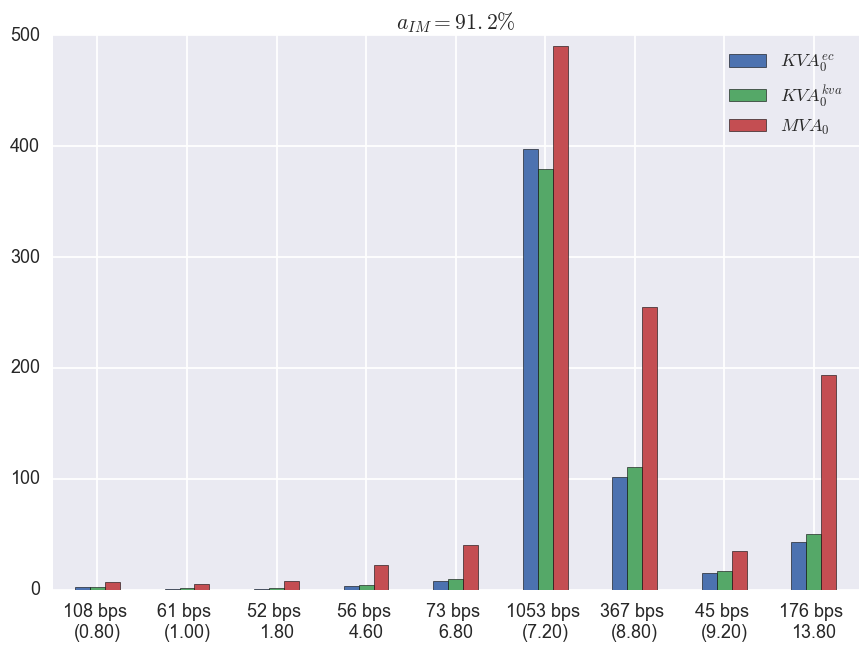

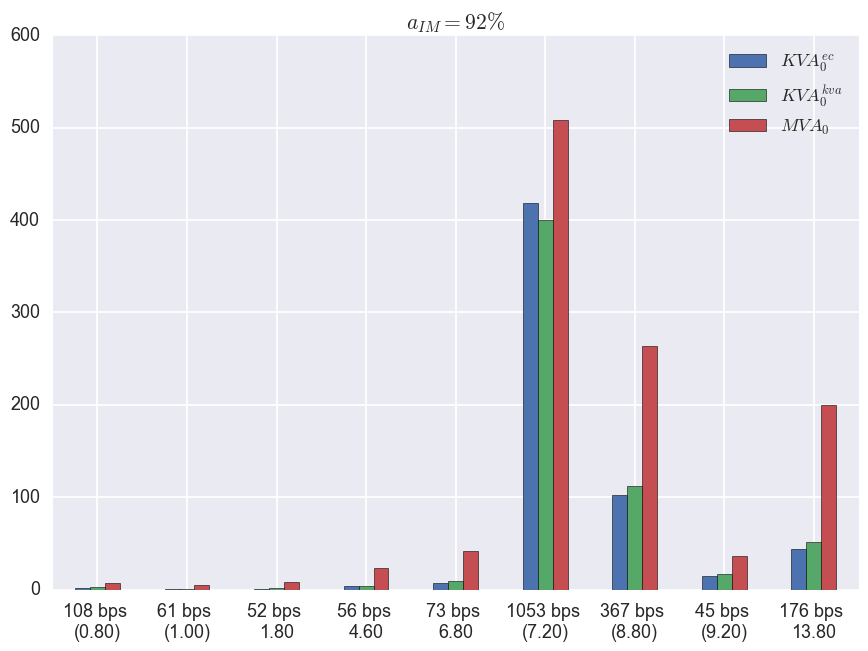

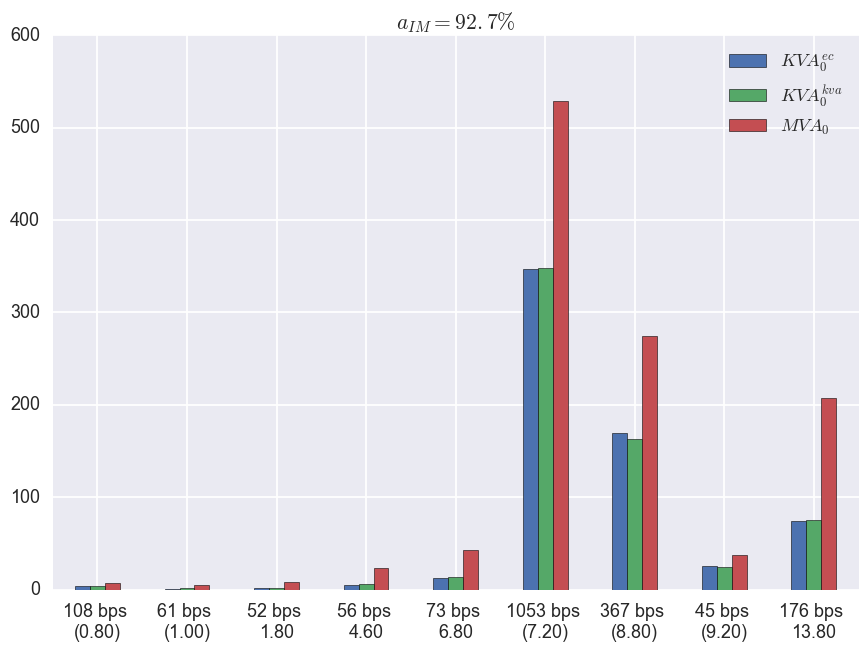

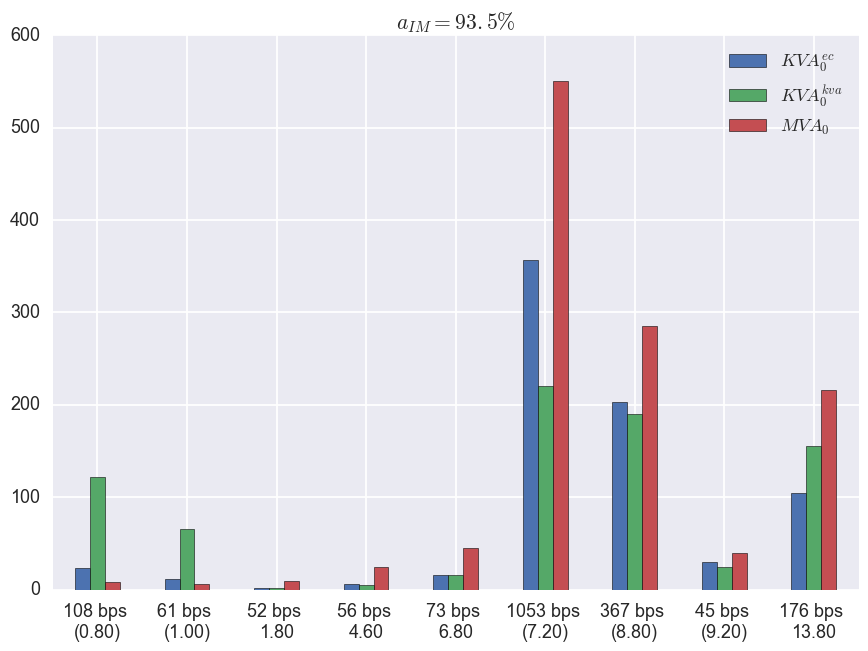

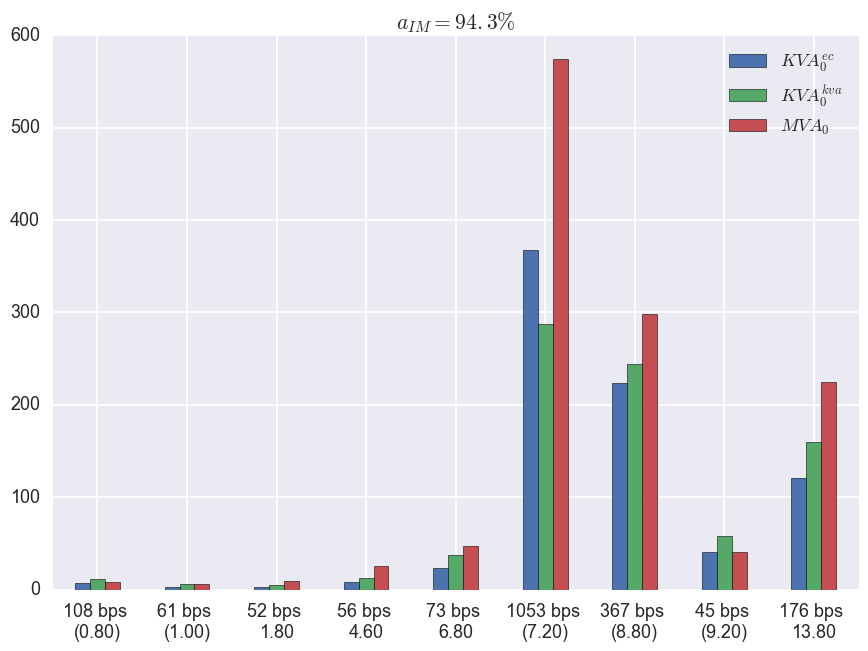

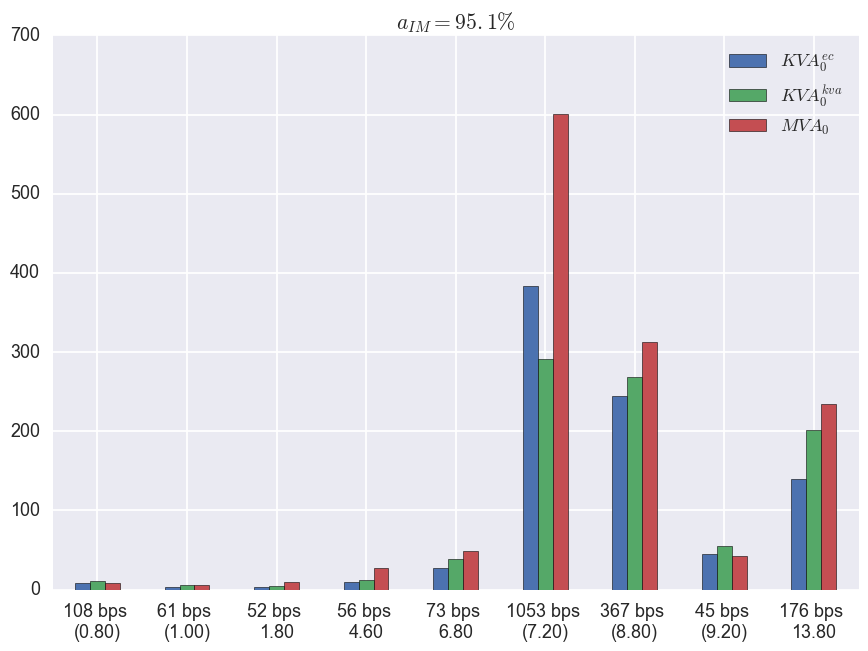

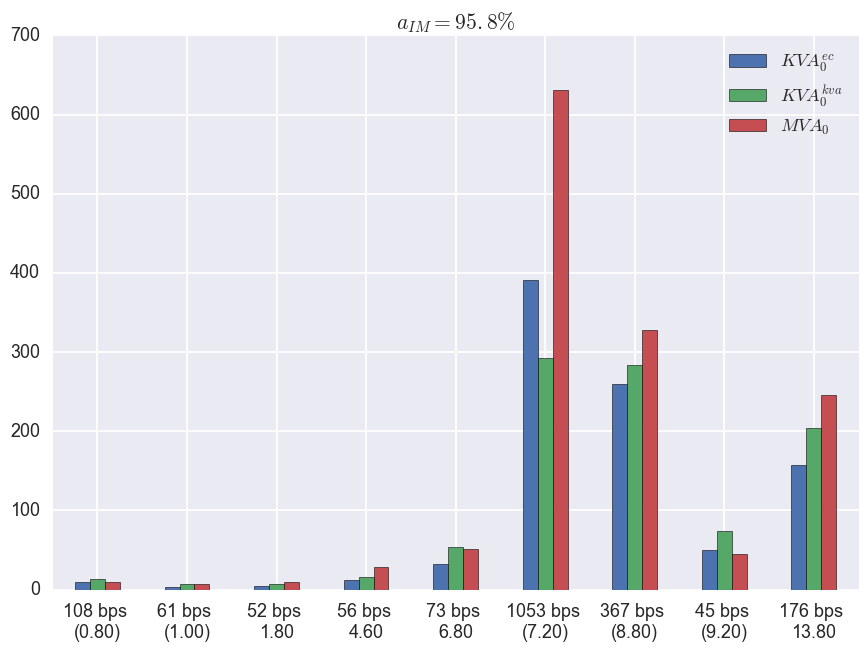

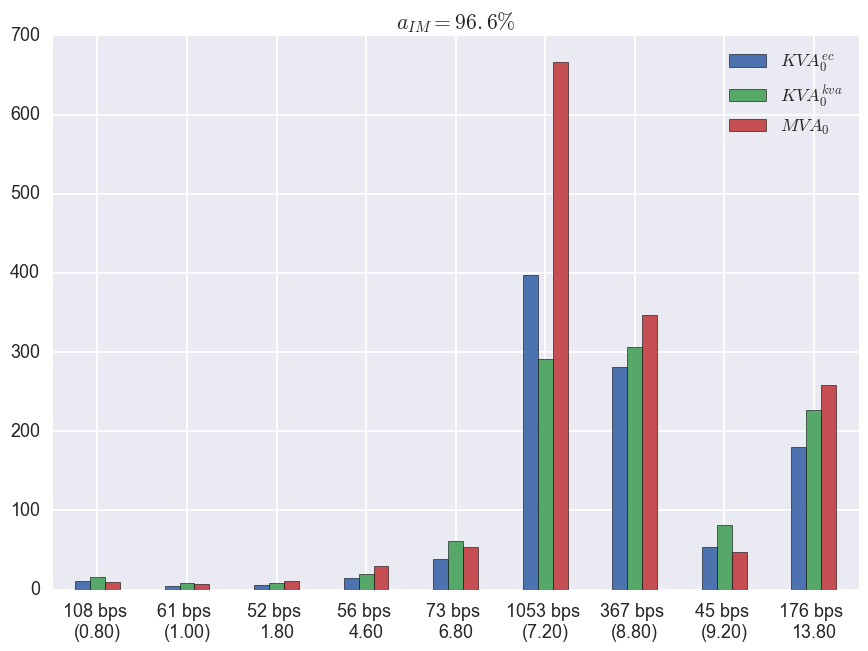

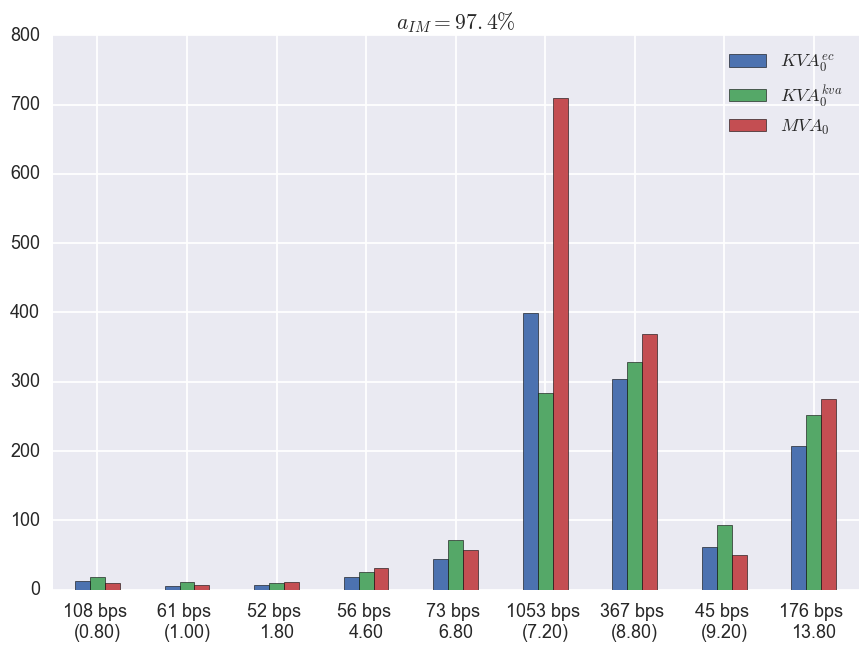

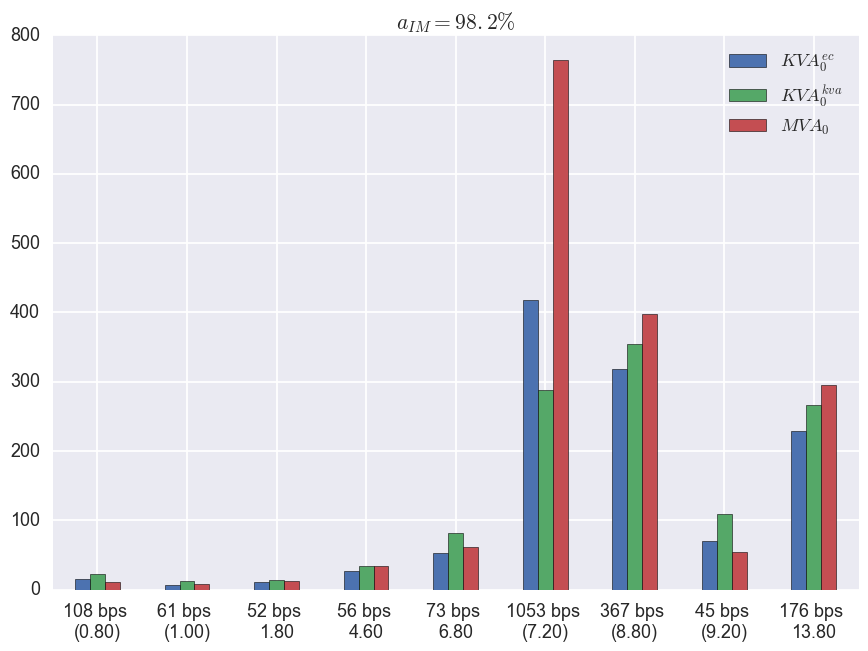

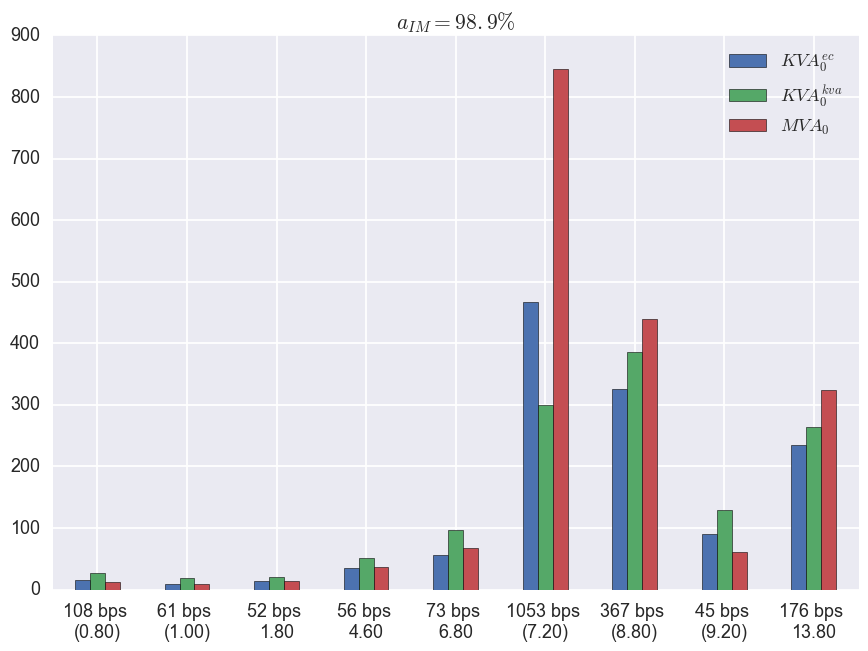

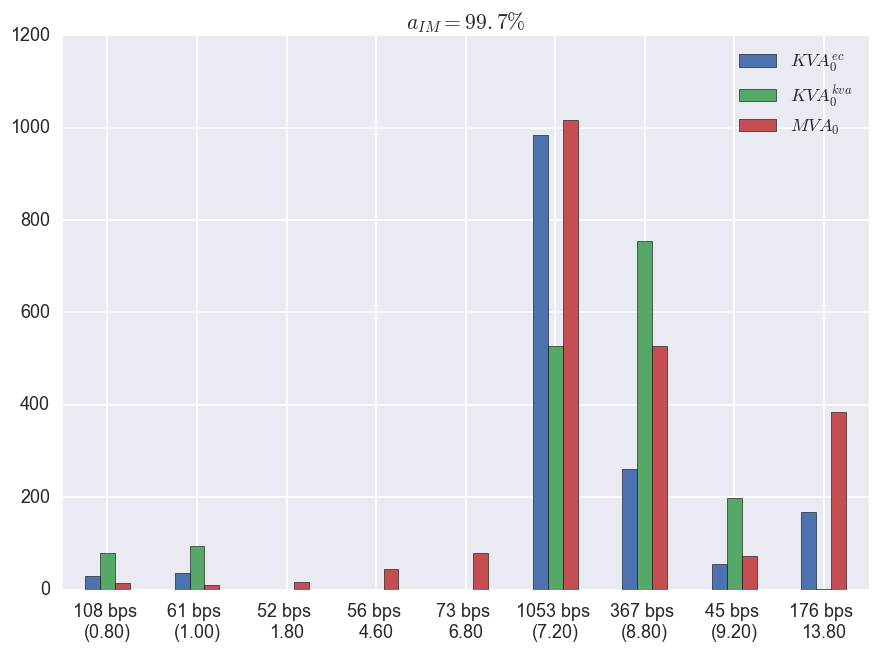

In [29]:
sorted_bc_ids = sorted(IDS_POSITIONS.items(), key=lambda x: np.abs(x[1]))
sorted_bc_ids = [x[0] for x in sorted_bc_ids]
labels_spreads = map(map_id_label, sorted_bc_ids)

plot(labels_spreads)

In [30]:
print QUANTILES
print ES_QUANTILES

[ 0.85        0.85773684  0.86547368  0.87321053  0.88094737  0.88868421
  0.89642105  0.90415789  0.91189474  0.91963158  0.92736842  0.93510526
  0.94284211  0.95057895  0.95831579  0.96605263  0.97378947  0.98152632
  0.98926316  0.997     ]
[0.9590295902970625, 0.9631696316953048, 0.9670696706964345, 0.9707897078956392, 0.9742697426982707, 0.9775397753989266, 0.9806098060982292, 0.9834398343987314, 0.9860598605979853, 0.9884398843987415, 0.9905799057983607, 0.9925199251985151, 0.9942199421976848, 0.9956799567998105, 0.9969099691007918, 0.9979299793007647, 0.9987299872986705, 0.9993199932002221, 0.9997499974998814, 0.9999899999008471]
